In [1]:
#used when run in colab
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.ticker as mtick 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score,f1_score,recall_score,confusion_matrix,auc,classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
import os
import lightgbm as lgb
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

#os.chdir("/content/gdrive/Shared drives/Marketing Analytics 2 Project")

In [5]:
bank_df = pd.read_csv("bank-additional-full.csv")

In [6]:
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Each record is details on a client for the bank

In [7]:
bank_df.shape

(41188, 21)

In [8]:
bank_df=bank_df.drop_duplicates()
bank_df.shape

(41176, 21)

After dropping duplicates, we have 41,176 records with 21 features.

# Data Pre-processing

In [0]:
bank_df=bank_df.round(1)

In [196]:
bank_df.isnull().sum() #checking for null values

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [197]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

In [198]:
bank_df.describe() #checking for outliers

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.574599,-40.502863,3.643596,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.583654,4.627860,1.752820,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.200000,-50.800000,0.600000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.100000,-42.700000,1.300000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.700000,-41.800000,4.900000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,94.000000,-36.400000,5.000000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.800000,-26.900000,5.000000,5228.100000


Duration (last contact duration in seconds) seems to be a feature with skewed data with max value at 81 minutes. This is a column that directly influences the output of the y varaible. So, we would essentially be dropping this while using it in our predictive model. For EDA, let's bin this variable.

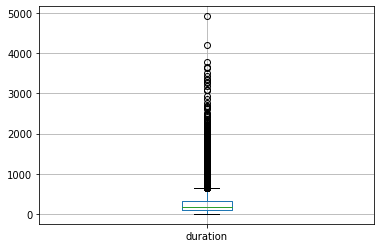

In [199]:
bank_df.boxplot(column=['duration'])

In [0]:
numerical_features=bank_df.columns[(bank_df.dtypes== 'float64') | (bank_df.dtypes=='int64')]
cat_cols = list(bank_df.select_dtypes(include=['object']))

In [201]:
numerical_features,cat_cols

(Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
        'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
       dtype='object'),
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome',
  'y'])

# EDA

**Distribution of numerical columns**

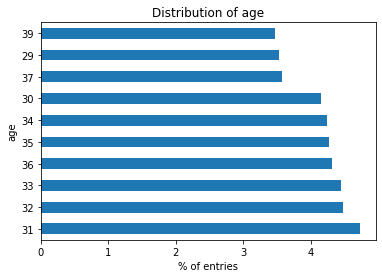

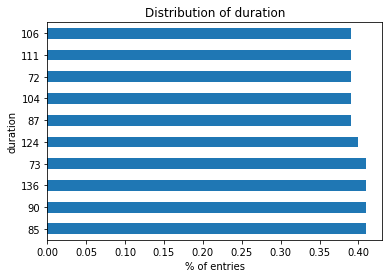

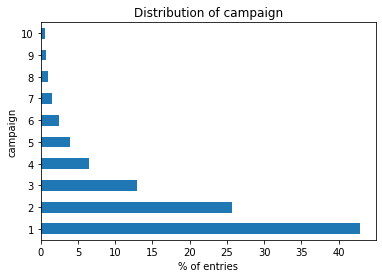

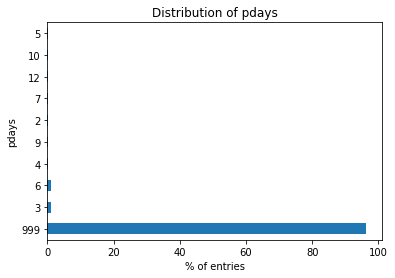

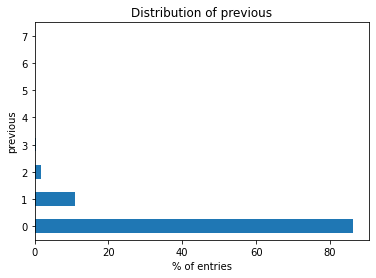

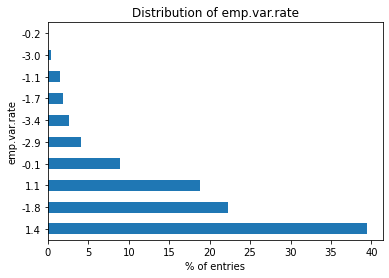

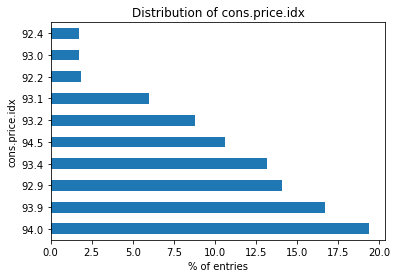

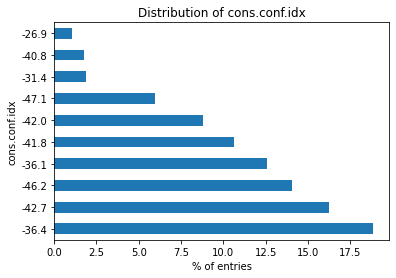

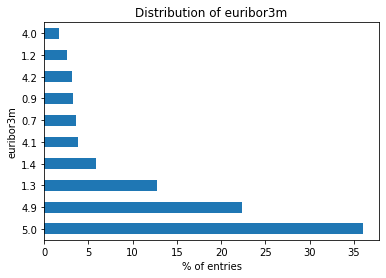

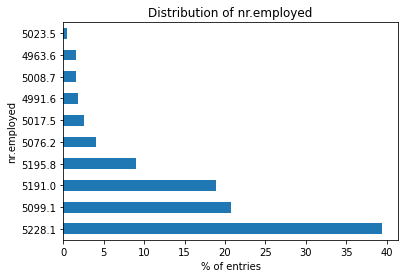

In [202]:
#distribution of numerical columns
def plot_dist(column):
    x=round((bank_df[column].value_counts()/bank_df.shape[0])*100,2).sort_values(ascending=False).nlargest(n=10)
    x.plot(kind='barh')
    plt.xlabel('% of entries')
    plt.ylabel(column)
    plt.title('Distribution of '+ column)

#plot for numerical columns
for i in range(0,len(numerical_features)):
    plot_dist(numerical_features[i])
    plt.show()

Observations:<br>1) 45% of the clients have been contacted only once during this campaign and around 82% of the clients have been contacted 3 times or less than that<br> 2)Majority of the clients (85%) of them have not been contacted before this campaign<br> 3) Around 20% of the clients have CPI of 94 indicating that there has been a 6% decrease in the price of the market basket in those areas compared to the reference period. The range of this variable is only around 2 indicating not a lot of variablility

**Distribution of categorical columns**

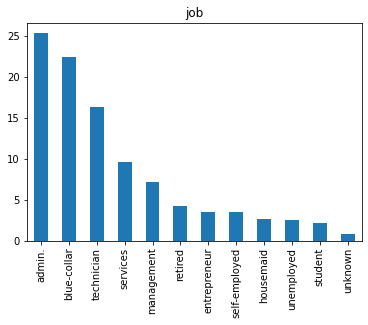

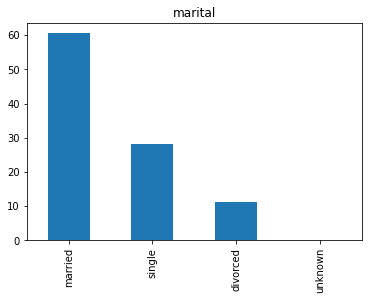

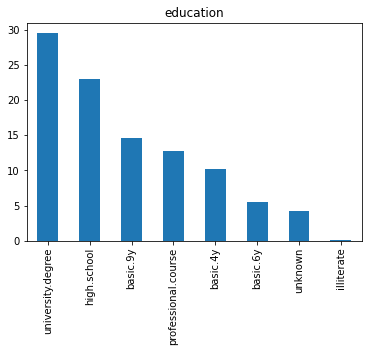

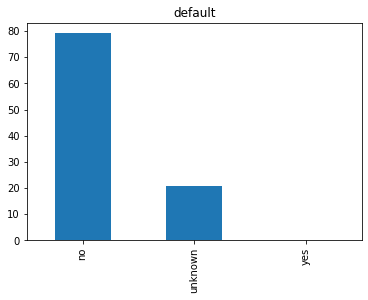

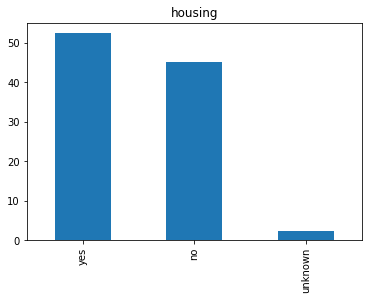

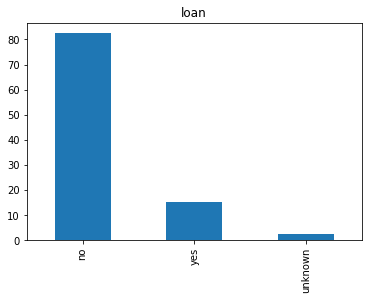

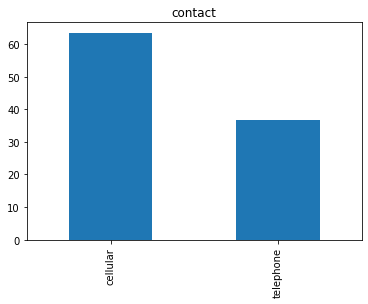

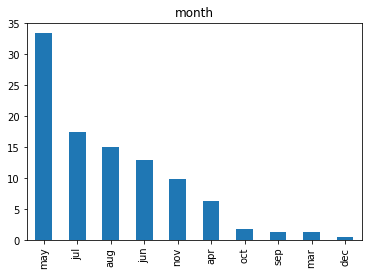

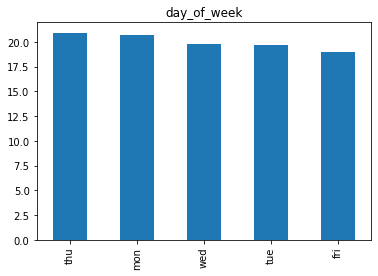

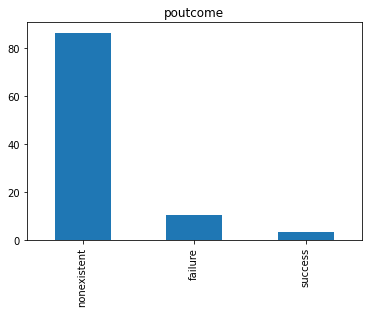

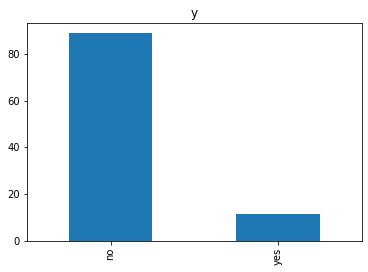

In [203]:
#plot for categorical columns
for col in cat_cols:
    (bank_df[col].value_counts()*100.0 /len(bank_df)).sort_values(ascending=False).plot(kind='bar')
    plt.title(col)
    plt.show()

Observations<br> 1) Less than 5% of the clients are unemployed and they have 25% admin and 23% blue-collar jobs. This is around 50% of their client-base. Given that term deposits have the money locked-in for a period of time, thesemajor segments of clients might not prefer it. The base that looks promising is the management and services segment which is about 17%.<br> 2) 60% married base who might want to save for families <br> 3) 30% of the base has a university degree and around 40% of the base has high school and basic.9y education level. This explains the  job profiles we saw and there seems to be correlation between these two.<br> 4) 80% does not have credit, around 50% of the base has a housing loan and 80% does not have personal loan. It might be a possibility that housing loan spend presses their expenses and hence they might find it difficult to save.<br> 5) Most clients (35%) have been last contacted in May <br> 5) There is no difference observed in the proportion of clients contacted during the week. This might be tied to the fact of calling capacity of the bank and it is probably equally planned on all days.<br> 6. The clients are (70%) of them between 30-54 years. This makes sense as this is probably the working professional age group that is salaried and would want to save <br> 7) The contact duration in the last campaign has been mostly (30%) 1.5 - less than 3 mins. The proportion seems to be almost split equally at both ends of the spectrum with 20% less than 1.5 mins and 20% at 5-less than 10 mins. There should be a check on length of call to avoid annoying the customer. <br> 8) Almost 97% of the clients have not been contacted in the previous campaign  

**Effect on Target variable:**

In [204]:
cat_cols.remove('y')
cat_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

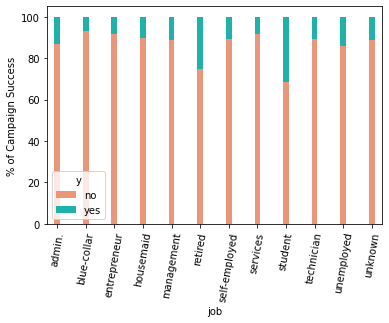

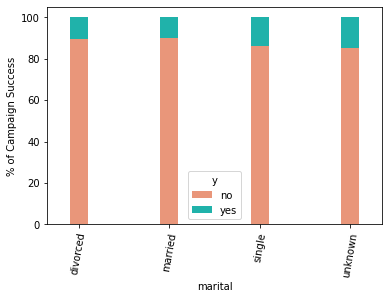

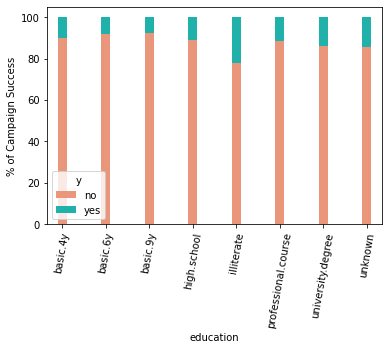

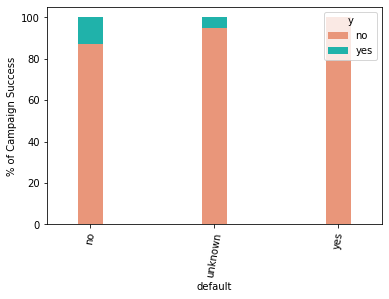

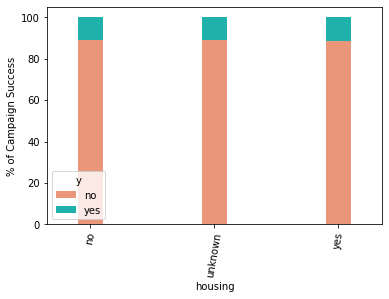

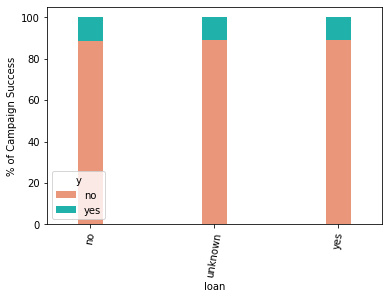

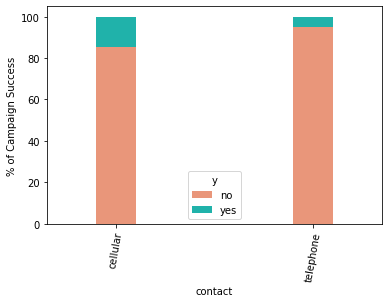

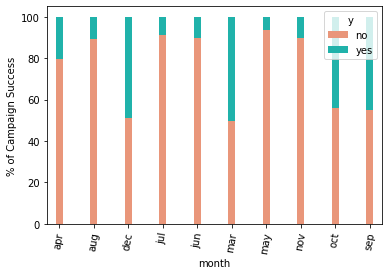

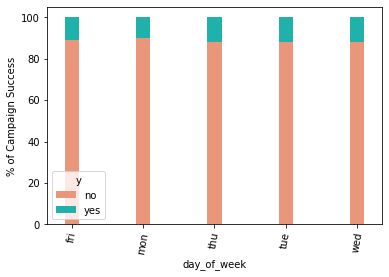

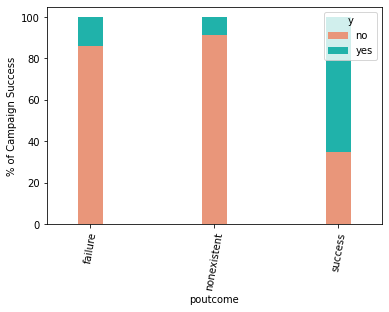

In [205]:
#effect of categorical columns on y
for col in cat_cols:
    temp_df = bank_df.groupby(['y',col])[['y']].count().unstack('y')
    temp_df.columns = temp_df.columns.droplevel()
    (temp_df.loc[:,].div(temp_df.sum(axis=1),axis=0)*100.0).plot(kind='bar',width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (6,4),
                                                                color = ['DarkSalmon','LightSeaGreen'])
    plt.xticks(rotation=80)
    plt.xlabel(col)
    plt.ylabel('% of Campaign Success')
    plt.show

Observations: <br> 1) It is seen that higher proportion of customers who took the term deposit are admins and itis higher than the proportion of people who did not take deposit. Also, there is no difference in the management job betwwen the two categories. <br> 2). It is quite surprising to see that being single has an effect on buying term dposit while the effect of married is otherwise.<br> 3) University degree people seem to be the higher proportion of people who buy term deposits. The professional course has no difference and ties well with the management category in job. <br> 4) If for a customer, the outcome of the previous marketing campaign was a success, then there is a higher probability of this campaign being a success


In [206]:
cat_cols.remove('default')
cat_cols

['job',
 'marital',
 'education',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

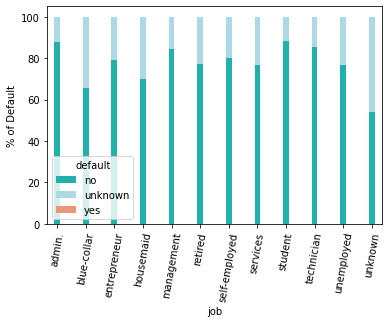

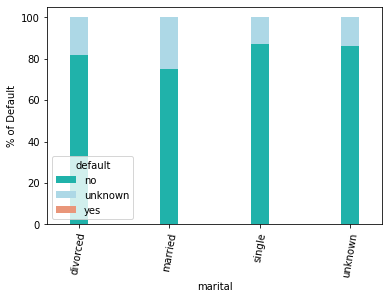

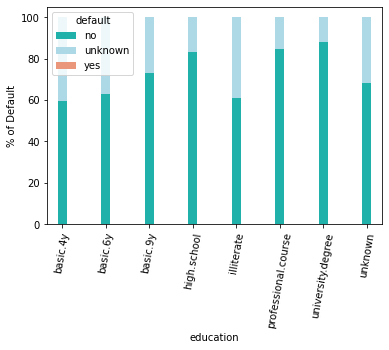

In [207]:
# Effect of job,marital and education on default
cols = ['job',
 'marital',
 'education']
for col in cols:
    temp_df = bank_df.groupby(['default',col])[['default']].count().unstack('default')
    temp_df.columns = temp_df.columns.droplevel()
    (temp_df.loc[:,].div(temp_df.sum(axis=1),axis=0)*100.0).plot(kind='bar',width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (6,4),
                                                                color = ['LightSeaGreen','LightBlue','DarkSalmon'])
    plt.xticks(rotation=80)
    plt.xlabel(col)
    plt.ylabel('% of Default')
    plt.show

<function matplotlib.pyplot.show>

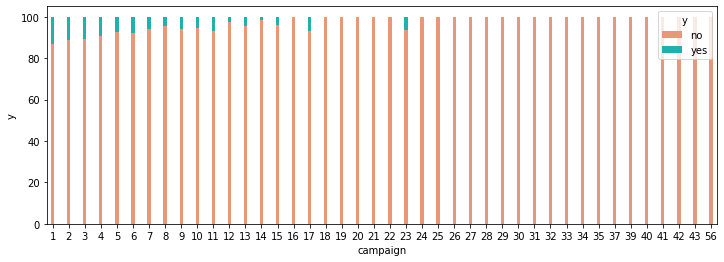

In [208]:
# Effect of campaign - number of contacts on label
col = 'campaign'
col_y = 'y'
temp_df = bank_df.groupby([col_y,col])[[col_y]].count().unstack(col_y)
temp_df.columns = temp_df.columns.droplevel()
(temp_df.loc[:,].div(temp_df.sum(axis=1),axis=0)*100.0).plot(kind='bar',width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (12,4),
                                                                color = ['DarkSalmon','LightSeaGreen'])
plt.xticks(rotation=0)
plt.xlabel(col)
plt.ylabel(col_y)
plt.show

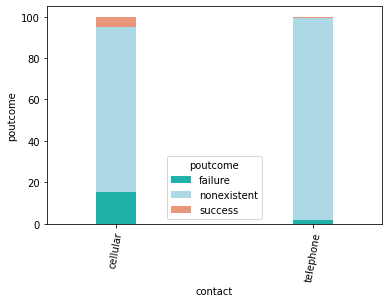

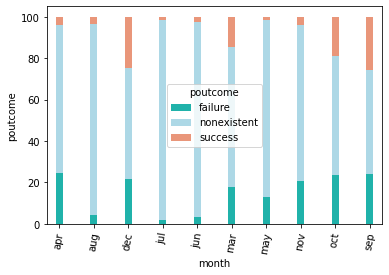

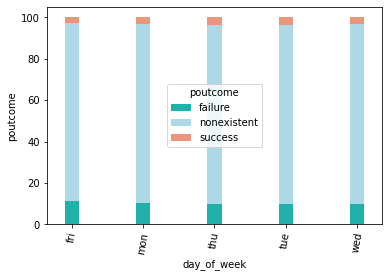

In [209]:
# Effect of contact, month and day of week on poutcome
cols = ['contact', 'month', 'day_of_week']
col_y = 'poutcome'

for col in cols:
    temp_df = bank_df.groupby([col_y,col])[[col_y]].count().unstack(col_y)
    temp_df.columns = temp_df.columns.droplevel()
    (temp_df.loc[:,].div(temp_df.sum(axis=1),axis=0)*100.0).plot(kind='bar',width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (6,4),
                                                                color = ['LightSeaGreen','LightBlue','DarkSalmon'])
    plt.xticks(rotation=80)
    plt.xlabel(col)
    plt.ylabel(col_y)
    plt.show

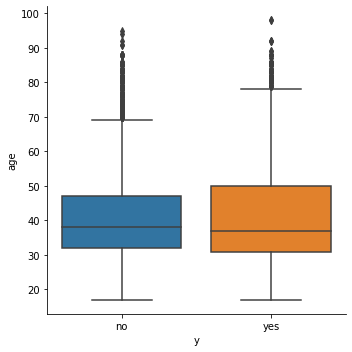

In [210]:
# Effect of age on label
sns.catplot(x="y", y="age", kind="box", data=bank_df);

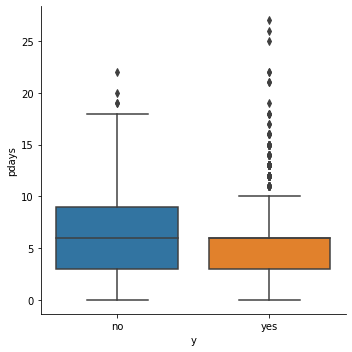

In [211]:
# Effect of pdays on label
sns.catplot(x="y", y="pdays", kind="box",data=bank_df[bank_df['pdays']<=150]);

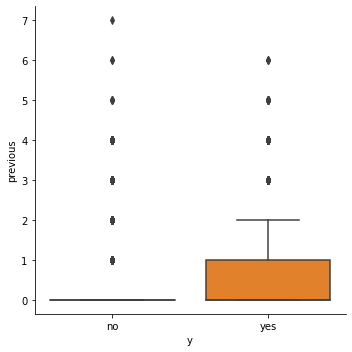

In [212]:
# Effect of previous on label
sns.catplot(x="y", y="previous", kind="box", data=bank_df);

FEATURE ENGINEERING

In [0]:
#age variable
bank_df['age_bucket']='greater than or eq 55'
bank_df['age_bucket']=np.where(bank_df['age']<18,'less than 18',
                 np.where((bank_df['age']>=18)&(bank_df['age']<29),'18-29',
                 np.where((bank_df['age']>=30)&(bank_df['age']<39),'30-39',
                 np.where((bank_df['age']>=40)&(bank_df['age']<55),'40-54',
                 bank_df['age_bucket']))))

#duration variable
bank_df['dur_bucket']='greater than or eq 10 mins'
bank_df['dur_bucket']=np.where(bank_df['duration']<1,'zero',
                 np.where((bank_df['duration']>=1)&(bank_df['duration']<90),'less than 1.5 mins',
                 np.where((bank_df['duration']>=90)&(bank_df['duration']<180),'1.5 - less than 3 mins',
                 np.where((bank_df['duration']>=180)&(bank_df['duration']<300),'3 - less than 5 mins',
                 np.where((bank_df['duration']>=300)&(bank_df['duration']<600),'5 - less than 10 mins',
                 bank_df['dur_bucket'])))))

#25% ot max value of pdays is 999. This shows that there is not much variation in this feature.
#So, for now making it a binary column with info on whether the customer was previously contacted or not.
bank_df['pdays_cat']='not contacted'
bank_df['pdays_cat']=np.where(bank_df['pdays']<999,'contacted',
                              bank_df['pdays_cat'])

#dropping off age,duration and pdays
bank_df=bank_df.drop(['age','duration','pdays'],axis=1)

In [214]:
#checking for correlation and dropping those variables
corr=bank_df.corr()
upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
corr_threshold=0.90
to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
to_drop

['euribor3m', 'nr.employed']

The social and economic attributes 'euribor3m' and 'nr.employed' is highly correlated and hence dropped.

In [215]:
bank_df=bank_df.drop(bank_df[to_drop], axis=1)
bank_df.shape

(41176, 19)

In [216]:
# Duration directly influences the label. To avoid data leakage, dropping the variable
bank_df=bank_df.drop('dur_bucket', axis=1)
bank_df.shape

(41176, 18)

#PREDICTOR SET AND LABEL

In [217]:
X = bank_df.loc[:, bank_df.columns != 'y'] #predictor set
y = bank_df['y']  #target variable

#checking for proportion of the classes in the label
y.value_counts()/bank_df.shape[0]*100

no     88.733728
yes    11.266272
Name: y, dtype: float64

# SPLIT TRAIN AND TEST

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,\
                                               random_state=78,stratify=y)

In [219]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((28823, 17), (12353, 17), (28823,), (12353,))

In [220]:
round(y_train.value_counts()/y_train.shape[0]*100,2)

no     88.73
yes    11.27
Name: y, dtype: float64

In [221]:
round(y_test.value_counts()/y_test.shape[0]*100,2)

no     88.73
yes    11.27
Name: y, dtype: float64

# BALANCING DATA


UPSAMPLE/DOWNSAMPLE

In [222]:
#sample
#run only when trying upsampling/downsampling. If trying SMOTE, please comment this block and do not run it.

merged_xy=X_train.merge(y_train,left_index=True,right_index=True)
not_label=merged_xy[merged_xy['y']=='no']
label=merged_xy[merged_xy['y']=='yes']

def sample(label,not_label,upsample=0):
  if upsample==0: #we are downsampling
    not_label_downsampled = resample(not_label,
                      replace = False, 
                      n_samples = len(label), # match minority n
                      random_state = 20)
    print('Downsampling...')
    X_train = pd.concat([not_label_downsampled, label])
    y_train=X_train['y']
    X_train=X_train.drop('y',axis=1)
    print(X_train.shape,y_train.shape)
    return(X_train,y_train)

  else: #we are upsampling
    label_upsampled = resample(label,
                      replace = True, 
                      n_samples = len(not_label), # match majority n
                      random_state = 20)
    print('Upsampling...')
    X_train = pd.concat([label_upsampled, not_label])
    y_train=X_train['y']
    X_train=X_train.drop('y',axis=1)
    print(X_train.shape,y_train.shape)
    return(X_train,y_train)

#calling function
X_train,y_train = sample(label,not_label,upsample=0)  

Downsampling...
(6494, 17) (6494,)


# ONE HOT ENCODING

In [223]:
X_train['status']='train'
X_test['status']='test'
merged=pd.concat([X_train,X_test])

#get dummies
merged=pd.get_dummies(merged,drop_first=True)

#split it back into train and test
X_train=merged[merged['status_train']==1]
X_test=merged[merged['status_train']==0]

#drop status column
X_train=X_train.drop('status_train',axis=1)
X_test=X_test.drop('status_train',axis=1)

#y column - change from binary character response to numerical [0,1]
y_train=y_train.replace(["yes","no"],[1,0])
y_test=y_test.replace(["yes","no"],[1,0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# SMOTE - run only when trying SMOTE, else please skip this block

In [182]:
# run only when trying SMOTE - commented for now
# columns = X_train.columns
# oversample = SMOTE(sampling_strategy='minority', random_state=0, k_neighbors=5)
# os_data_X,os_data_y=oversample.fit_sample(X_train, y_train)
# X_train = pd.DataFrame(data=os_data_X,columns=columns)
# y_train = pd.DataFrame(data=os_data_y,columns=['y'])
# print(X_train.shape,y_train.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(51152, 53) (51152, 1)


CHECKING FOR COLLINEARITY

In [224]:
#checking for correlation and dropping those variables
correlation=X_train.corr()
upper_correlation = correlation.where(np.triu(np.ones(correlation.shape),k=1).astype(np.bool))
correlation_threshold=0.90
to_drop_collinear = [column for column in upper_correlation.columns if any(upper_correlation[column] > correlation_threshold)]
print('Dropping variable',to_drop_collinear)

#dropping the variables
X_train=X_train.drop(to_drop_collinear,axis=1)
X_test=X_test.drop(to_drop_collinear,axis=1)

Dropping variable ['loan_unknown']


In [225]:
#checking for columns with zero variance
to_drop_zero_var=(X_train.loc[:,X_train.var()== 0]).columns
print('Dropping variable',to_drop_zero_var)

#dropping the variables
X_train=X_train.drop(to_drop_zero_var,axis=1)
X_test=X_test.drop(to_drop_zero_var,axis=1)

Dropping variable Index(['default_yes'], dtype='object')


EXPORTING FILE TO USE IN R (LOGIT, PROBIT AND CLOGLOG MODEL). It was observed that AIC and BIC of the logit model was the lowest making it the best model.

In [0]:
# train=X_train.merge(y_train,left_index=True,right_index=True)
# test=X_test.merge(y_test,left_index=True,right_index=True)
# from google.colab import files
# train.to_csv('train.csv') 
# files.download('train.csv')
# test.to_csv('test.csv') 
# files.download('test.csv')

#MODELLING

In [0]:
def predict(x_tr,x_te,y_tr,y_te,model,threshold):

    try:
      model.fit(x_tr,y_tr)
    except:
      pass  

    try:  
      tr_probs=model.predict_proba(x_tr)
      y_pred_tr = tr_probs[:,1]

      te_probs=model.predict_proba(x_te)
      y_pred_te = te_probs[:,1]
    
    except:
      y_pred_tr=model.predict(x_tr)
      y_pred_te=model.predict(x_te)


  #train
    y_predicted_tr = np.where(y_pred_tr[:]>threshold,1,0)   

  #test
    y_predicted_te = np.where(y_pred_te[:]>threshold,1,0)


    #test confusion matrix
    con_05 = confusion_matrix(y_te,y_predicted_te)
    print(pd.DataFrame(con_05, columns=['pred(neg)', 'pred(pos)']))
    
    #normal model
    print("Classification report for classifier-train")
    print("AUROC: ", roc_auc_score(y_tr, y_pred_tr[:]))
    print()
    print(classification_report(y_tr, y_predicted_tr))

    print("Classification report for classifier-test")
    print("AUROC: ", roc_auc_score(y_te, y_pred_te[:]))
    print()
    print(classification_report(y_te, y_predicted_te))

    return(model)

STAT MODEL LOGISTIC

In [227]:
x = sm.add_constant(X_train, prepend=False)
y = y_train

fit = sm.Logit(y,x).fit(method='bfgs',maxiter=10000)
fit.summary()

Optimization terminated successfully.
         Current function value: 0.527082
         Iterations: 389
         Function evaluations: 396
         Gradient evaluations: 396


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6494
Model:                          Logit   Df Residuals:                     6442
Method:                           MLE   Df Model:                           51
Date:                Mon, 18 May 2020   Pseudo R-squ.:                  0.2396
Time:                        01:50:01   Log-Likelihood:                -3422.9
converged:                       True   LL-Null:                       -4501.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
campaign                            -0.0461      0.014     -3.315      0.001      -0.073      -0.019
previous                            -0.2504      0.132     -1.897      0.058      -0.509       0.008
emp.var.rate                        -0.7842      0.048    -16.231      0.000      -0.879      -0.689
cons.price.idx                       1.2738      0.131      9.690      0.000       1.016       1.531
cons.conf.idx                        0.0232      0.009      2.511      0.012       0.005       0.041
job_blue-collar                     -0.2061      0.111     -1.853      0.064      -0.424       0.012
job_entrepreneur                     0.1809      0.175      1.034      0.301      -0.162       0.524
job_housemaid                        0.0834      0.217      0.385      0.700      -0.341       0.508
job_management                      -0.1085      0.126     -0.858      0.391      -0.356       0.139
job_retired                          0.1004      0.163      0.616      0.538      -0.219       0.420
job_self-employed                    0.0325      0.167      0.195      0.846      -0.295       0.360
job_services                        -0.2144      0.122     -1.761      0.078      -0.453       0.024
job_student                          0.3833      0.219      1.748      0.080      -0.046       0.813
job_technician                      -0.0619      0.103     -0.598      0.550      -0.265       0.141
job_unemployed                      -0.0869      0.203     -0.427      0.669      -0.486       0.312
job_unknown                          0.2535      0.387      0.655      0.512      -0.505       1.012
marital_married                      0.0070      0.098      0.071      0.943      -0.184       0.198
marital_single                       0.1257      0.111      1.134      0.257      -0.092       0.343
marital_unknown                      0.6889      0.565      1.219      0.223      -0.419       1.796
education_basic.6y                   0.1906      0.165      1.152      0.249      -0.134       0.515
education_basic.9y                   0.0762      0.133      0.575      0.565      -0.184       0.336
education_high.school               -0.0633      0.132     -0.478      0.632      -0.323       0.196
education_illiterate                 1.2907      1.206      1.070      0.285      -1.073       3.654
education_professional.course       -0.0919      0.147     -0.626      0.531      -0.380       0.196
education_university.degree          0.0902      0.134      0.671      0.502      -0.173       0.353
education_unknown                    0.1621      0.183      0.887      0.375      -0.196       0.520
default_unknown                     -0.3057      0.085     -3.577      0.000      -0.473      -0.138
housing_unknown                     -0.2309      0.199     -1.160      0.246      -0.621       0.159
housing_yes                         -0.0643      0.061     -1.062      0.288      -0.183       0.054
loan_yes 

In [0]:
# getting significant columns
significant_columns=(X_train.loc[:,fit.pvalues<=0.05]).columns

In [0]:
X_train=X_train[significant_columns]
X_test=X_test[significant_columns]

LOGISTIC REGRESSION

In [230]:
result_lr=predict(x_tr=X_train,x_te=X_test,y_tr=y_train,y_te=y_test,
                  model=LogisticRegression(random_state=35,max_iter=10000),threshold=0.48)

   pred(neg)  pred(pos)
0       9038       1923
1        506        886
Classification report for classifier-train
AUROC:  0.7976249474889

              precision    recall  f1-score   support

           0       0.71      0.83      0.76      3247
           1       0.79      0.66      0.72      3247

    accuracy                           0.74      6494
   macro avg       0.75      0.74      0.74      6494
weighted avg       0.75      0.74      0.74      6494

Classification report for classifier-test
AUROC:  0.782769690501433

              precision    recall  f1-score   support

           0       0.95      0.82      0.88     10961
           1       0.32      0.64      0.42      1392

    accuracy                           0.80     12353
   macro avg       0.63      0.73      0.65     12353
weighted avg       0.88      0.80      0.83     12353



The intercept is [-110.93963942]
The coefficients are


Text(0.5, 0, 'feature coefficient weights')

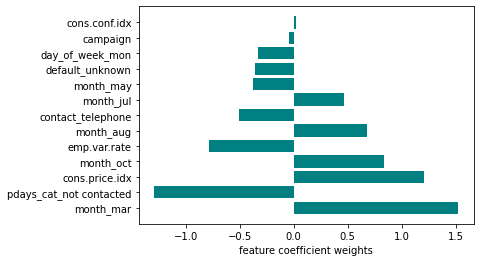

In [231]:
print("The intercept is",result_lr.intercept_)
print("The coefficients are")

weights_f = Series(result_lr.coef_[0],
                 index=X_train.columns.values)
weights_f2 = DataFrame(dict(weights = weights_f, weights_abs = weights_f.abs()))
weights_f2 = weights_f2.sort_values(by='weights_abs',ascending=False)
weights_f2 = weights_f2.reset_index().rename(columns={'index': 'Features'})

# plot the feature weights
fig = plt.figure()
ax = plt.subplot(111)
ax.barh(weights_f2['Features'][:20], weights_f2['weights'][:20], color='teal')
ax.set_xlabel('feature coefficient weights')

RANDOM FOREST

In [232]:
result_rf=predict(x_tr=X_train,x_te=X_test,y_tr=y_train,y_te=y_test,model=RandomForestClassifier(random_state=35),threshold=0.48)

   pred(neg)  pred(pos)
0       8997       1964
1        533        859
Classification report for classifier-train
AUROC:  0.842844533282671

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      3247
           1       0.83      0.68      0.74      3247

    accuracy                           0.77      6494
   macro avg       0.78      0.77      0.77      6494
weighted avg       0.78      0.77      0.77      6494

Classification report for classifier-test
AUROC:  0.7700257089660626

              precision    recall  f1-score   support

           0       0.94      0.82      0.88     10961
           1       0.30      0.62      0.41      1392

    accuracy                           0.80     12353
   macro avg       0.62      0.72      0.64     12353
weighted avg       0.87      0.80      0.83     12353



In [233]:
# Number of trees in random forest
n_estimators = [20,50,100]
# Maximum number of levels in tree
max_depth = [5,10,15]
# Minimum number of samples required to split a node
min_samples_split = [5,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Method of evalutaion
criterion = ['gini','entropy']

tuned_parameters = [{'n_estimators':n_estimators,
                     'criterion': criterion,
                     'max_depth':max_depth,
                     'min_samples_split':min_samples_split,
                     'min_samples_leaf':min_samples_leaf,
                     'bootstrap':bootstrap}]
clf1 = GridSearchCV(RandomForestClassifier(random_state=35), tuned_parameters,cv=5,scoring='f1')
clf1.fit(X_train, y_train)
print(clf1.best_params_)

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 20}


In [234]:
result_rf_tuned=predict(x_tr=X_train,x_te=X_test,y_tr=y_train,y_te=y_test,
                        model=clf1.best_estimator_,threshold=0.48)

   pred(neg)  pred(pos)
0       8424       2537
1        434        958
Classification report for classifier-train
AUROC:  0.8054765484881972

              precision    recall  f1-score   support

           0       0.72      0.77      0.75      3247
           1       0.76      0.71      0.73      3247

    accuracy                           0.74      6494
   macro avg       0.74      0.74      0.74      6494
weighted avg       0.74      0.74      0.74      6494

Classification report for classifier-test
AUROC:  0.7839035761062996

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     10961
           1       0.27      0.69      0.39      1392

    accuracy                           0.76     12353
   macro avg       0.61      0.73      0.62     12353
weighted avg       0.87      0.76      0.80     12353



Text(0.5, 1.0, 'Feature importance')

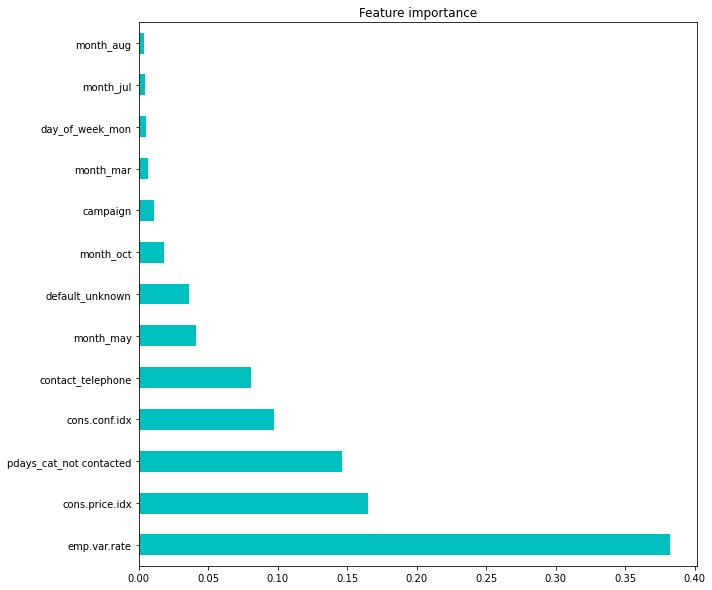

In [235]:
feat_importances = pd.Series(result_rf_tuned.feature_importances_, index=X_train.columns)
plt.figure(figsize=(10,10)) 
feat_importances.sort_values(ascending=False)[:20].plot(kind='barh',color='c')
plt.title('Feature importance')

SVM Classifier

In [236]:
# gamma=scale, C=1, kernel = rbf
result_svm=predict(x_tr=X_train,x_te=X_test,y_tr=y_train,y_te=y_test,model=SVC(random_state=35,probability=True,gamma='scale',C=1,kernel='rbf'),threshold=0.48)

   pred(neg)  pred(pos)
0       7873       3088
1        411        981
Classification report for classifier-train
AUROC:  0.7373682883131372

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      3247
           1       0.72      0.72      0.72      3247

    accuracy                           0.72      6494
   macro avg       0.72      0.72      0.72      6494
weighted avg       0.72      0.72      0.72      6494

Classification report for classifier-test
AUROC:  0.7315030916824227

              precision    recall  f1-score   support

           0       0.95      0.72      0.82     10961
           1       0.24      0.70      0.36      1392

    accuracy                           0.72     12353
   macro avg       0.60      0.71      0.59     12353
weighted avg       0.87      0.72      0.77     12353



Light GBM Classifier

In [0]:
## creating data as LightGBM format
#categorical_columns = ['favor_day','Weekend','Afternoon_peak','Evening_peak']
lgb_train = lgb.Dataset(X_train, label=y_train) #,categorical_feature=categorical_columns)
lgb_test = lgb.Dataset(X_test, label=y_test)#,categorical_feature=categorical_columns)

In [0]:
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    "max_depth" : 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'learning_rate': 0.15,
    'verbose': 1
    #,"is_unbalance": 'True'
}

In [239]:
result_lgb=predict(x_tr=X_train,x_te=X_test,y_tr=y_train,y_te=y_test,model = lgb.train(parameters,
                       lgb_train,
                       valid_sets=lgb_test,
                       num_boost_round=5000,
                       early_stopping_rounds=300),threshold=0.48)

[1]	valid_0's auc: 0.784989
Training until validation scores don't improve for 300 rounds.
[2]	valid_0's auc: 0.784754
[3]	valid_0's auc: 0.786655
[4]	valid_0's auc: 0.787269
[5]	valid_0's auc: 0.78665
[6]	valid_0's auc: 0.786412
[7]	valid_0's auc: 0.786438
[8]	valid_0's auc: 0.786299
[9]	valid_0's auc: 0.786734
[10]	valid_0's auc: 0.78694
[11]	valid_0's auc: 0.78725
[12]	valid_0's auc: 0.787114
[13]	valid_0's auc: 0.787256
[14]	valid_0's auc: 0.786842
[15]	valid_0's auc: 0.786553
[16]	valid_0's auc: 0.786811
[17]	valid_0's auc: 0.786971
[18]	valid_0's auc: 0.787122
[19]	valid_0's auc: 0.787382
[20]	valid_0's auc: 0.787369
[21]	valid_0's auc: 0.787389
[22]	valid_0's auc: 0.786567
[23]	valid_0's auc: 0.786213
[24]	valid_0's auc: 0.78637
[25]	valid_0's auc: 0.786436
[26]	valid_0's auc: 0.785908
[27]	valid_0's auc: 0.78606
[28]	valid_0's auc: 0.786153
[29]	valid_0's auc: 0.785748
[30]	valid_0's auc: 0.785583
[31]	valid_0's auc: 0.785273
[32]	valid_0's auc: 0.78512
[33]	valid_0's auc: 0.78

Text(0.5, 1.0, 'Feature importance')

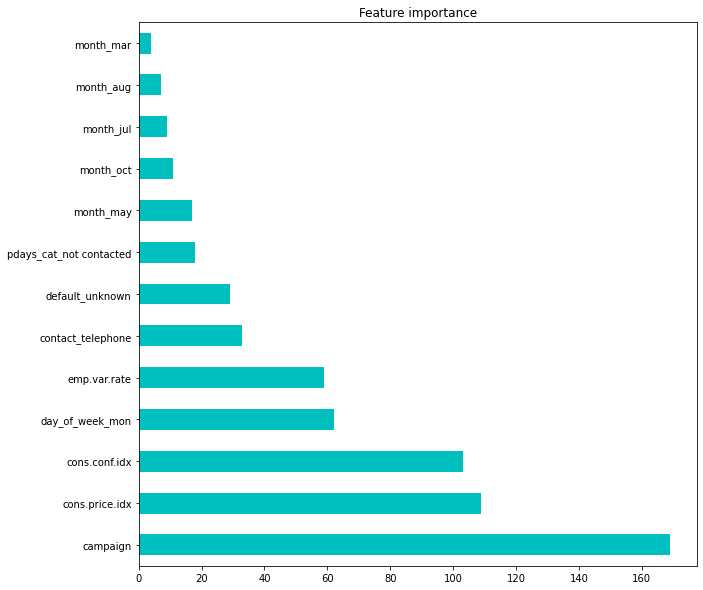

In [240]:
feat_importances = pd.Series(data=result_lgb.feature_importance(), index=X_train.columns)
plt.figure(figsize=(10,10)) 
feat_importances.sort_values(ascending=False)[:20].plot(kind='barh',color='c')
plt.title('Feature importance')

CAT BOOST

In [245]:
!pip install catboost
import catboost as catboost
from catboost import Pool, CatBoostClassifier,cv

     |████████████████████████████████| 64.7MB 66kB/s 


In [0]:
## creating data as Catboost format
cat_train = Pool(X_train, label=y_train) #,categorical_feature=categorical_columns)
cat_test = Pool(X_test, label=y_test)#,categorical_feature=categorical_columns)

In [0]:
cat_boost_model = CatBoostClassifier(subsample=0.6,
                           custom_loss='Logloss',
                           l2_leaf_reg = 10,
                           random_strength = 0,
                           max_depth=12,
                           eval_metric="AUC",
                           learning_rate=0.1,
                           iterations=60000,
                           bootstrap_type='Bernoulli',
                           random_seed=42,
                           od_type="Iter")

In [248]:
result_cat=predict(x_tr=cat_train,x_te=cat_test,y_tr=y_train,y_te=y_test,
                        model=cat_boost_model.fit(cat_train,verbose_eval=1000, early_stopping_rounds=100,eval_set=[cat_test],use_best_model=True,plot=True),threshold=0.48)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7774460	best: 0.7774460 (0)	total: 62.5ms	remaining: 1h 2m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7818277406
bestIteration = 2

Shrink model to first 3 iterations.
   pred(neg)  pred(pos)
0       8554       2407
1        448        944
Classification report for classifier-train
AUROC:  0.8170579196128922

              precision    recall  f1-score   support

           0       0.72      0.79      0.76      3247
           1       0.77      0.70      0.73      3247

    accuracy                           0.74      6494
   macro avg       0.75      0.74      0.74      6494
weighted avg       0.75      0.74      0.74      6494

Classification report for classifier-test
AUROC:  0.7818277406206122

              precision    recall  f1-score   support

           0       0.95      0.78      0.86     10961
           1       0.28      0.68      0.40      1392

    accuracy                           0.77     12353
   macro avg       0.62      0.73

Text(0.5, 1.0, 'Feature importance')

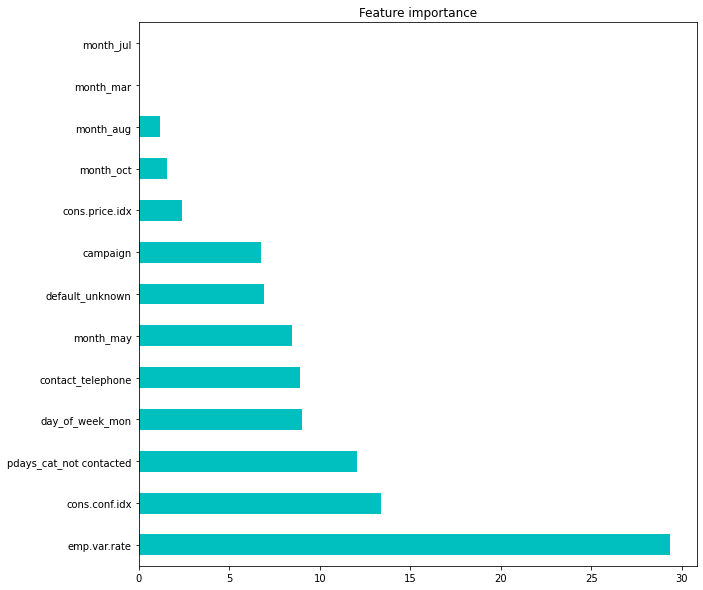

In [249]:
feat_importances = pd.Series(data=result_cat.get_feature_importance(), index=X_train.columns)
plt.figure(figsize=(10,10)) 
feat_importances.sort_values(ascending=False)[:20].plot(kind='barh',color='c')
plt.title('Feature importance')